# Imports

In [1285]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV, RFE
import xgboost

from skopt import BayesSearchCV
from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import PredefinedSplit


# Settings

In [1286]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


# Read data

In [1287]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Adding building ID

In [1288]:
train_a['building_id'] = 'a'
train_b['building_id'] = 'b'
train_c['building_id'] = 'c'

X_train_estimated_a['building_id'] = 'a'
X_train_estimated_b['building_id'] = 'b'
X_train_estimated_c['building_id'] = 'c'

X_train_observed_a['building_id'] = 'a'
X_train_observed_b['building_id'] = 'b'
X_train_observed_c['building_id'] = 'c'

X_test_estimated_a['building_id'] = 'a'
X_test_estimated_b['building_id'] = 'b'
X_test_estimated_c['building_id'] = 'c'

# Combine data

In [1289]:
# Combine Data
X_o = pd.concat([X_train_observed_a, X_train_observed_b, X_train_observed_c])
X_e = pd.concat([X_train_estimated_a, X_train_estimated_b, X_train_estimated_c])
X_submission = pd.concat([X_test_estimated_a, X_test_estimated_b, X_test_estimated_c])
y = pd.concat([train_a, train_b, train_c])

# Add isEstimated column
X_o['isEstimated'] = 0
X_e['isEstimated'] = 1
X_submission['isEstimated'] = 1


# Combine
X = pd.concat([X_o, X_e])

# Add time column that only holds the hour
X['time'] = X['date_forecast'].dt.floor('H')
X_submission['time'] = X_submission['date_forecast'].dt.floor('H')

# combine X and y
Xy = pd.merge(X, y, on=['building_id', 'time'], how='inner')

# Add monthYear column
Xy['monthYear'] = Xy['date_forecast'].dt.to_period('M')
X_submission['monthYear'] = X_submission['date_forecast'].dt.to_period('M')

# Add dayMonthYear column
Xy['dayMonthYear'] = Xy['date_forecast'].dt.to_period('D')
X_submission['dayMonthYear'] = X_submission['date_forecast'].dt.to_period('D')

# Add month column
Xy['month'] = Xy['date_forecast'].dt.month
X_submission['month'] = X_submission['date_forecast'].dt.month

# Add hour column
Xy['hour'] = Xy['date_forecast'].dt.hour
X_submission['hour'] = X_submission['date_forecast'].dt.hour

# Prepare for joining ->The data is grouped per building and hour
Xy = Xy.groupby(['building_id', 'time']).mean().reset_index()
X_submission = X_submission.groupby(['building_id', 'time']).mean().reset_index()

# Create additional feature for estimated data "delta_forecast"
Xy['delta_forecast'] = (Xy['time']-Xy['date_calc']).apply(lambda x: x.total_seconds() / 3600)
X_submission['delta_forecast'] = (X_submission['time']-X_submission['date_calc']).apply(lambda x: x.total_seconds() / 3600)

#TODO: remove, only for testing
# Xy_o = Xy_o[Xy_o['building_id'] == 'a']
# Xy_e = Xy_e[Xy_e['building_id'] == 'a']





In [1290]:
X_submission['date_forecast'].describe()


count                   2160
mean     2023-06-05 22:16:30
min      2023-05-01 00:22:30
25%      2023-05-23 12:07:30
50%      2023-06-03 23:52:30
75%      2023-06-19 11:37:30
max      2023-07-03 23:22:30
Name: date_forecast, dtype: object

# Feature engineering

In [1291]:
max_val = 1

Xy['GHI'] = Xy['diffuse_rad:W'] + Xy['direct_rad:W']
Xy['wind_angle'] = np.arctan2(Xy['wind_speed_u_10m:ms'], Xy['wind_speed_v_10m:ms'])
Xy['norm_radiation'] = (Xy['GHI'] / Xy['clear_sky_rad:W']).fillna(0)
Xy.loc[Xy['norm_radiation'] > max_val, 'norm_radiation'] = max_val

X_submission['GHI'] = X_submission['diffuse_rad:W'] + X_submission['direct_rad:W']
X_submission['wind_angle'] = np.arctan2(X_submission['wind_speed_u_10m:ms'], X_submission['wind_speed_v_10m:ms'])
X_submission['norm_radiation'] = (X_submission['GHI'] / X_submission['clear_sky_rad:W']).fillna(0)
X_submission.loc[X_submission['norm_radiation'] > max_val, 'norm_radiation'] = max_val


# Lagged Features

In [1292]:
# lagged feature of GHI
Xy['GHI_lag-2'] = Xy.groupby('building_id')['GHI'].shift(-2)
Xy['GHI_lag-1'] = Xy.groupby('building_id')['GHI'].shift(-1)
Xy['GHI_lag1'] = Xy.groupby('building_id')['GHI'].shift(1)
Xy['GHI_lag2'] = Xy.groupby('building_id')['GHI'].shift(2)

X_submission['GHI_lag-2'] = X_submission.groupby('building_id')['GHI'].shift(-2)
X_submission['GHI_lag-1'] = X_submission.groupby('building_id')['GHI'].shift(-1)
X_submission['GHI_lag1'] = X_submission.groupby('building_id')['GHI'].shift(1)
X_submission['GHI_lag2'] = X_submission.groupby('building_id')['GHI'].shift(2)

# remove rows were lagged features are nan
Xy = Xy.dropna(subset=['GHI_lag-2', 'GHI_lag-1', 'GHI_lag1', 'GHI_lag2'])


# Daily Mean

In [1293]:
# add daily mean of GHI
Xy['GHI_mean'] = Xy.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('mean')
X_submission['GHI_mean'] = X_submission.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('mean')



# Feature differences  

In [1294]:
Xy['GHI_0_minus_-1'] = Xy['GHI'] - Xy['GHI_lag-1']
Xy['GHI_0_minus_-2'] = Xy['GHI'] - Xy['GHI_lag-2']
Xy['GHI_0_minus_1'] = Xy['GHI'] - Xy['GHI_lag1']
Xy['GHI_0_minus_2'] = Xy['GHI'] - Xy['GHI_lag2']

X_submission['GHI_0_minus_-1'] = X_submission['GHI'] - X_submission['GHI_lag-1']
X_submission['GHI_0_minus_-2'] = X_submission['GHI'] - X_submission['GHI_lag-2']
X_submission['GHI_0_minus_1'] = X_submission['GHI'] - X_submission['GHI_lag1']
X_submission['GHI_0_minus_2'] = X_submission['GHI'] - X_submission['GHI_lag2']

# Feature Interactions

In [1295]:
Xy.columns

Index(['building_id', 'time', 'date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms',

# Preprocessing

In [1296]:
# Class to scale y
class Y_Scaler_MaxAbs_per_building:
    def __init__(self):
        self.max_per_building = {}

    def fit(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        self.max_per_building = y_bid.groupby('cat')['y'].max().to_dict()
        return self

    def transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] / self.max_per_building[row['cat']], axis=1)
        return y

    def fit_transform(self, y, cat):
        self.fit(y, cat)
        return self.transform(y, cat)

    def inverse_transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] * self.max_per_building[row['cat']], axis=1)
        return y


In [1297]:
# Scale y
#y_scaler = Y_Scaler_MaxAbs_per_building()
#y_o = y_scaler.fit_transform(y_o, X_o['building_id'])
#y_e = y_scaler.transform(y_e, X_e['building_id']) # no fit_transform because we use y_e as test data


# Scale whole y
# full_scaler = RobustScaler()
# y_o = full_scaler.fit_transform(y_o.values.reshape(-1, 1)).flatten()
# y_e = full_scaler.transform(y_e.values.reshape(-1, 1)).flatten() # no fit_transform because we use y_e as test data



In [1298]:
Xy['temp*GHI'] = Xy['GHI'] * Xy['t_1000hPa:K']
Xy['wind*humidity'] = Xy['wind_speed_10m:ms'] * Xy['relative_humidity_1000hPa:p']
Xy['sun_height*diff_rad'] = Xy['sun_elevation:d'] * Xy['diffuse_rad:W']

# chat GPT
Xy['hour*wind_speed_10m'] = Xy['hour'] * Xy['wind_speed_10m:ms']
Xy['hour*clear_sky_rad'] = Xy['hour'] * Xy['clear_sky_rad:W']
Xy['month*sun_elevation'] = Xy['month'] * Xy['sun_elevation:d']

Xy['relative_humidity*air_density'] = Xy['relative_humidity_1000hPa:p'] * Xy['air_density_2m:kgm3']
Xy['temperature*wind_speed'] = Xy['t_1000hPa:K'] * Xy['wind_speed_10m:ms']

Xy['GHI*clear_sky_energy'] = Xy['GHI'] * Xy['clear_sky_energy_1h:J']
Xy['GHI*sun_azimuth'] = Xy['GHI'] * Xy['sun_azimuth:d']

Xy['snow_depth*temp*GHI'] = Xy['snow_depth:cm'] * Xy['temp*GHI']

Xy['GHI_lag_interaction'] = Xy['GHI_lag-1'] * Xy['GHI_lag-2'] * Xy['GHI_lag1'] * Xy['GHI_lag2']
Xy['GHI_lag_interaction_all'] = Xy['GHI_lag-1'] * Xy['GHI_lag-2'] * Xy['GHI_lag1'] * Xy['GHI_lag2'] * Xy['GHI']

Xy['wind_speed*temp*GHI'] = Xy['wind_speed_10m:ms'] * Xy['t_1000hPa:K'] * Xy['GHI']

Xy['cloud_base*clear_sky_energy'] = Xy['cloud_base_agl:m'] * Xy['clear_sky_energy_1h:J']

Xy['precip*sun_elevation'] = Xy['precip_5min:mm'] * Xy['sun_elevation:d']
Xy['supercooled_water*wind_speed'] = Xy['super_cooled_liquid_water:kgm2'] * Xy['wind_speed_10m:ms']


In [1299]:
X_submission['temp*GHI'] = X_submission['GHI'] * X_submission['t_1000hPa:K']
X_submission['wind*humidity'] = X_submission['wind_speed_10m:ms'] * X_submission['relative_humidity_1000hPa:p']
X_submission['sun_height*diff_rad'] = X_submission['sun_elevation:d'] * X_submission['diffuse_rad:W']

# chat GPT
X_submission['hour*wind_speed_10m'] = X_submission['hour'] * X_submission['wind_speed_10m:ms']
X_submission['hour*clear_sky_rad'] = X_submission['hour'] * X_submission['clear_sky_rad:W']
X_submission['month*sun_elevation'] = X_submission['month'] * X_submission['sun_elevation:d']

X_submission['relative_humidity*air_density'] = X_submission['relative_humidity_1000hPa:p'] * X_submission['air_density_2m:kgm3']
X_submission['temperature*wind_speed'] = X_submission['t_1000hPa:K'] * X_submission['wind_speed_10m:ms']

X_submission['GHI*clear_sky_energy'] = X_submission['GHI'] * X_submission['clear_sky_energy_1h:J']
X_submission['GHI*sun_azimuth'] = X_submission['GHI'] * X_submission['sun_azimuth:d']

X_submission['snow_depth*temp*GHI'] = X_submission['snow_depth:cm'] * X_submission['temp*GHI']

X_submission['GHI_lag_interaction'] = X_submission['GHI_lag-1'] * X_submission['GHI_lag-2'] * X_submission['GHI_lag1'] * X_submission['GHI_lag2']
X_submission['GHI_lag_interaction_all'] = X_submission['GHI_lag-1'] * X_submission['GHI_lag-2'] * X_submission['GHI_lag1'] * X_submission['GHI_lag2'] * X_submission['GHI']

X_submission['wind_speed*temp*GHI'] = X_submission['wind_speed_10m:ms'] * X_submission['t_1000hPa:K'] * X_submission['GHI']

X_submission['cloud_base*clear_sky_energy'] = X_submission['cloud_base_agl:m'] * X_submission['clear_sky_energy_1h:J']

X_submission['precip*sun_elevation'] = X_submission['precip_5min:mm'] * X_submission['sun_elevation:d']
X_submission['supercooled_water*wind_speed'] = X_submission['super_cooled_liquid_water:kgm2'] * X_submission['wind_speed_10m:ms']

# Preparing X and y

In [1300]:
Xy.columns

Index(['building_id', 'time', 'date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms',

In [1301]:
# drop empty pv_measurement
Xy = Xy.dropna(subset=['pv_measurement'])

test_idx = Xy['date_forecast'].between('2021/05/01','2021/07/01') 

Xy_train = Xy[~test_idx].reset_index(drop=True)
Xy_test = Xy[test_idx].reset_index(drop=True)

# shuffle data
Xy_train = Xy_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Use only data from March to September
Xy_train = Xy_train[Xy_train['month'].between(4,7)].reset_index(drop=True)

# create custom split
val_idx = Xy_train['date_forecast'].between('2020/05/01', '2020/07/01') - 1
ps = PredefinedSplit(test_fold=val_idx)

# Remove data where sun_elevation is below -5
#Xy_train = Xy_train[Xy_train['sun_elevation:d'] >= -10].reset_index(drop=True)


X = Xy.drop(columns=['pv_measurement'])
y = Xy['pv_measurement']

X_train = Xy_train.drop(columns=['pv_measurement'])
y_train = Xy_train['pv_measurement']

X_test = Xy_test.drop(columns=['pv_measurement'])
y_test = Xy_test['pv_measurement']


In [1302]:
Xy


,building_id,time,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,isEstimated,date_calc,pv_measurement,monthYear,dayMonthYear,month,hour,delta_forecast,GHI,wind_angle,norm_radiation,GHI_lag-2,GHI_lag-1,GHI_lag1,GHI_lag2,GHI_mean,GHI_0_minus_-1,GHI_0_minus_-2,GHI_0_minus_1,GHI_0_minus_2,temp*GHI,wind*humidity,sun_height*diff_rad,hour*wind_speed_10m,hour*clear_sky_rad,month*sun_elevation,relative_humidity*air_density,temperature*wind_speed,GHI*clear_sky_energy,GHI*sun_azimuth,snow_depth*temp*GHI,GHI_lag_interaction,GHI_lag_interaction_all,wind_speed*temp*GHI,cloud_base*clear_sky_energy,precip*sun_elevation,supercooled_water*wind_speed
0,a,2020-04-01 00:00:00,2020-04-01 00:22:30,4.825,1.27175,5107.149902,0.000000,0.000000,469.949982,0.0,273.225006,0.000000,0.000000,0.000000,0.000000,96.500000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1009.150024,0.0,0.0,996.050049,1002.275024,0.0,0.0,82.550003,1008.500000,NaN,0.0,0.0,0.0,0.0,15.947500,-20.925251,0.100,275.299988,99.824997,18596.125000,4.400,4.375,0.550,0.0,0.0,NaT,0.00,2020-04,2020-04-01,4.0,0.0,NaN,0.000000,1.445738,0.000000,0.000000,0.000000,0.000000,0.000000,49.778126,0.000000,0.000000,0.000000,0.000000,0.000000,363.220032,-0.000000,0.000000,0.000000,-83.701004,104.982964,1211.319946,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,-0.0,0.4400
1,a,2020-04-01 01:00:00,2020-04-01 01:22:30,4.775,1.27075,3879.175049,0.000000,0.000000,673.400024,0.0,273.024994,0.000000,0.000000,0.000000,0.000000,99.400002,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1008.125000,0.0,0.0,995.050049,1001.250000,0.0,0.0,81.750000,1007.500000,NaN,0.0,0.0,0.0,0.1,31.600000,-18.225000,0.000,275.274994,100.000000,15879.199219,3.950,3.750,1.275,0.0,0.0,NaT,0.00,2020-04,2020-04-01,4.0,1.0,NaN,0.000000,1.243058,0.000000,0.000000,0.000000,0.000000,0.000000,49.778126,0.000000,0.000000,0.000000,0.000000,0.000000,322.912506,-0.000000,3.950000,0.000000,-72.900002,103.883820,1087.336182,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,-0.0,0.0000
2,a,2020-04-01 02:00:00,2020-04-01 02:22:30,4.725,1.27000,3626.875000,0.000000,0.000000,1300.675049,0.0,272.975006,0.000000,0.000000,0.000000,0.000000,99.474998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1007.049988,0.0,0.0,994.049988,1000.250000,0.0,0.0,82.224998,1006.450012,NaN,0.0,0.0,0.0,0.1,46.578751,-14.002000,0.000,275.200012,100.000000,21865.275391,3.800,3.500,1.500,0.0,0.0,NaT,0.00,2020-04,2020-04-01,4.0,2.0,NaN,0.000000,1.165905,0.000000,0.050000,0.000000,0.000000,0.000000,49.778126,0.000000,-0.050000,0.000000,0.000000,0.000000,312.454987,-0.000000,7.600000,0.000000,-56.007999,104.425743,1045.760010,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,-0.0,0.0000
3,a,2020-04-01 03:00:00,2020-04-01 03:22:30,4.800,1.27100,2963.774902,0.000000,0.000000,1963.625000,0.0,273.049988,0.000000,0.000000,0.000000,0.000000,99.925003,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1005.849976,0.0,0.0,992.849976,999.049988,0.0,0.0,84.150002,1005.250000,NaN,0.0,0.0,0.0,0.1,60.851250,-8.603750,0.000,275.100006,100.000000,24358.300781,3.250,2.900,1.450,0.0,0.0,NaT,0.00,2020-04,2020-04-01,4.0,3.0,NaN,0.000000,1.107149,0.000000,14.900000,0.050000,0.000000,0.000000,49.778126,-0.050000,-14.900000,0.000000,0.000000,0.000000,273.487518,-0.000000,9.750000,0.000000,-34.4

In [1303]:
val_idx


0       -1
1        0
2       -1
3        0
4       -1
        ..
19617    0
19618    0
19619   -1
19620   -1
19621    0
Name: date_forecast, Length: 19622, dtype: int64

In [1304]:
print(f"X.shape: {Xy_train.shape}")
print(f"X.shape: {Xy_test.shape}")


X.shape: (19622, 85)
X.shape: (4392, 85)


In [1305]:
# drop irrelevant columns
drop_cols = ['time', 'date_forecast', 'snow_density:kgm3',
             'date_calc', 'monthYear', 'dayMonthYear']

drop2 = ['clear_sky_energy_1h:J',
         'direct_rad_1h:J',
         'fresh_snow_24h:cm',
         'fresh_snow_1h:cm',
         'fresh_snow_12h:cm',
         'diffuse_rad_1h:J',
         'dew_point_2m:K',
         'dew_or_rime:idx',
         'precip_5min:mm',
         'fresh_snow_6h:cm',
         'prob_rime:p',
         'ceiling_height_agl:m',
         'rain_water:kgm2',
         'sfc_pressure:hPa',
         'snow_depth:cm',
         'snow_drift:idx',
         'snow_melt_10min:mm',
         'snow_water:kgm2',
         'pressure_50m:hPa',
         'wind_speed_w_1000hPa:ms',
         'pressure_100m:hPa',
         'fresh_snow_3h:cm']

drop_cols = drop_cols  # + drop2

print(drop_cols)
# ignore if column does not exist
X_train = X_train.drop(drop_cols, axis=1, errors='ignore')
X_test = X_test.drop(drop_cols, axis=1, errors='ignore')
# ignore if column does not exist
X = X.drop(drop_cols, axis=1, errors='ignore')
X_submission = X_submission.drop(drop_cols, axis=1, errors='ignore')


['time', 'date_forecast', 'snow_density:kgm3', 'date_calc', 'monthYear', 'dayMonthYear']


In [1306]:
# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train.loc[:, X.isna().any()].columns.tolist()

print(f"categorical_features: {categorical_features}")
print(f"impute_features: {impute_features}")


categorical_features: ['building_id']
impute_features: ['ceiling_height_agl:m', 'cloud_base_agl:m', 'delta_forecast', 'cloud_base*clear_sky_energy']


# Building the pipeline

In [1307]:
from sklearn.base import BaseEstimator, TransformerMixin


class StatusSaver(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # append "1," to status file
        with open('status.csv', 'a') as f:
            f.write('1\n')

        return self

    def transform(self, X):
        # Your transformation logic here
        # Return the transformed data
        return X


# create empty txt file
open('status.csv', 'w').close()


In [1308]:


# BayesSearchCV
parameters_bayes = {
    'estimator__n_estimators': Integer(30,500),
    'estimator__max_depth': Integer(6, 14),
    'estimator__learning_rate': Real(0.01, 0.3),
    # 'estimator__subsample': Real(0.5, 1.0),
    # 'estimator__colsample_bytree': Real(0.8, 1.0),
    # 'estimator__colsample_bylevel': Real(0.8, 1.0),
    # 'estimator__colsample_bynode': Real(0.8, 1.0),
    #'estimator__gamma': Real(0, 2),
    'estimator__reg_alpha': Real(0, 10),
    'estimator__reg_lambda': Real(1, 10),
    'estimator__min_child_weight': Integer(1, 10),
    #'estimator__max_delta_step': Integer(0, 5)
}

parameters_grid = {
    'estimator__n_estimators': [20,25,30,35,40,45,50,55,60,65,70,75,100,150,200,250,300],
    # 'estimator__max_depth': list(range(3,14)),
    # 'estimator__learning_rate': [0.3]#np.arange(0.01, 0.2, 0.01)
    # 'estimator__subsample': [0.9,1],
    # 'estimator__colsample_bytree': np.arange(0.3, 1, 0.01),
    # 'estimator__gamma': [0, 0.5, 1, 1.5, 2],
    # 'estimator__reg_alpha': np.arange(0, 10, 0.5),
    # 'estimator__reg_lambda': np.arange(0, 10, 0.5),
    # 'estimator__min_child_weight': np.arange(0.5, 20, 0.5),
    # 'estimator__n_estimators': [75],

}


In [1309]:
from sklearn.model_selection import PredefinedSplit

# set column transformer
columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

# build the pipeline
pipeline = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('statusSaver', StatusSaver()),
    ('estimator', xgboost.XGBRegressor(
        random_state=42,
        learning_rate=0.1,
        max_depth=6,
        reg_alpha=8,
        reg_lambda=5,
        n_estimators=45,
        colsample_bytree=1,
        min_child_weight=3,
        ))
])





# create bayesian search estimator
m1_BayesCV = BayesSearchCV(
    pipeline, parameters_bayes, scoring='neg_mean_absolute_error', cv=6, error_score='raise',n_points=6, n_jobs=-1, verbose=2, n_iter=1080, random_state=42)


m1_GridCV = GridSearchCV(
    pipeline, parameters_grid, scoring='neg_mean_absolute_error', cv=ps, error_score='raise', n_jobs=-1, verbose=2, refit=True)

# switch between BayesCV and GridCV
m1_CV = m1_GridCV

# fit the estimator on the data
#m1_CV.fit(X_o, y_o)
m1_CV.fit(X_train, y_train)

# get best model 
m1 = m1_CV.best_estimator_


Fitting 1 folds for each of 17 candidates, totalling 17 fits


[CV] END .........................estimator__n_estimators=20; total time=   0.6s
[CV] END .........................estimator__n_estimators=25; total time=   0.6s
[CV] END .........................estimator__n_estimators=30; total time=   0.7s
[CV] END .........................estimator__n_estimators=35; total time=   0.7s
[CV] END .........................estimator__n_estimators=40; total time=   0.8s
[CV] END .........................estimator__n_estimators=45; total time=   0.8s
[CV] END .........................estimator__n_estimators=50; total time=   0.8s
[CV] END .........................estimator__n_estimators=55; total time=   0.9s
[CV] END .........................estimator__n_estimators=60; total time=   0.7s
[CV] END .........................estimator__n_estimators=65; total time=   0.8s
[CV] END .........................estimator__n_estimators=70; total time=   0.9s
[CV] END .........................estimator__n_estimators=75; total time=   0.9s
[CV] END ...................

In [1310]:
# print the scores
print('Best score:', m1_CV.best_score_)
print('Best parameters:', m1_CV.best_params_)


Best score: -158.7097783242375
Best parameters: {'estimator__n_estimators': 50}


In [1311]:
#sns.lineplot(m1_CV.cv_results_['mean_test_score'])

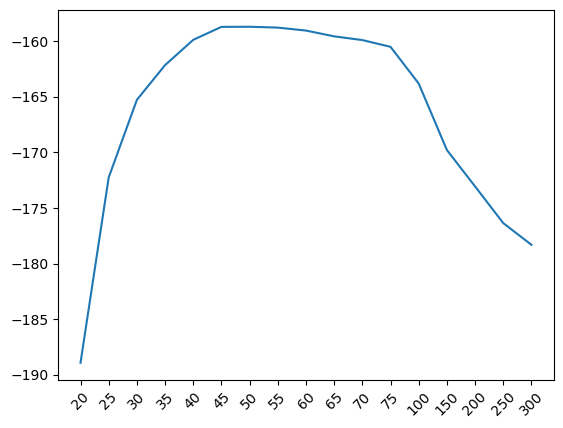

In [1312]:

for key, values in m1_CV.param_grid.items():
    pass

ax = plt.gca()

sns.lineplot(y=m1_CV.cv_results_['mean_test_score'], x=list(map(str, values)))
plt.xticks(rotation=45);


In [1313]:
#m1.steps[-3][1].get_feature_names_out()


<Axes: xlabel='feature'>

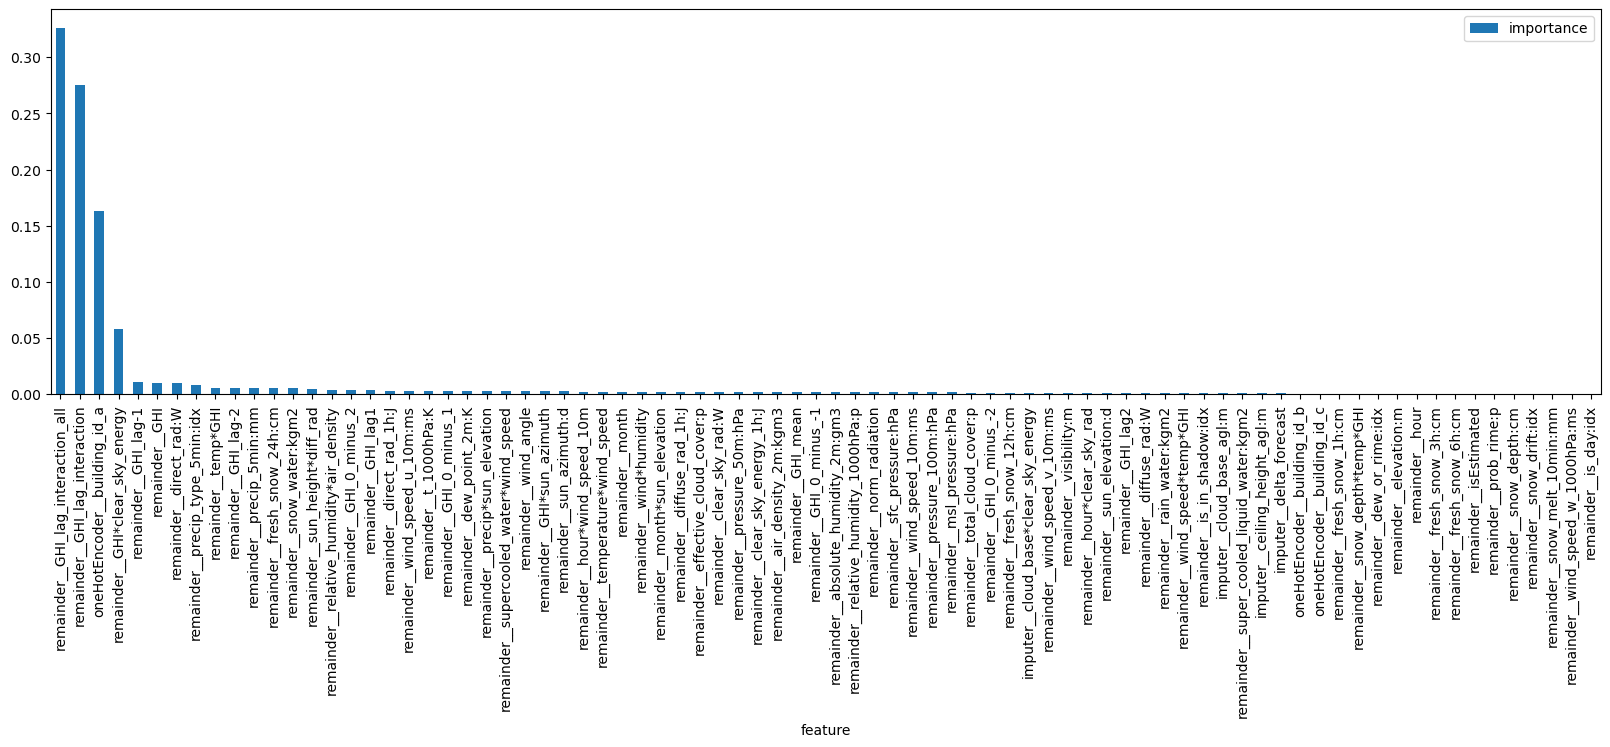

In [1314]:
f_names = m1.steps[-3][1].get_feature_names_out()
f_importances = m1.steps[-1][1].feature_importances_

f_importances_df = pd.DataFrame({'feature': f_names, 'importance': f_importances})

f_importances_df = f_importances_df.sort_values(by='importance', ascending=False)

f_importances_df.plot.bar(x='feature', y='importance', figsize=(20, 5))


In [1315]:
if type(m1_CV) == BayesSearchCV:
    _ = plot_objective(m1_CV.optimizer_results_[0])
    plt.show()

# Test model on test data

In [1316]:
# predict on estimated data
m1_pred = pd.Series(m1.predict(X_test))
#m1_pred = pd.Series(full_scaler.inverse_transform(m1_pred.values.reshape(-1, 1)).flatten())
#m1_pred = y_scaler.inverse_transform(m1_pred, X_e['building_id'])
Xy_test['m1_pred'] = m1_pred

# calculate abs diff
Xy_test['abs_diff'] = np.abs(Xy_test['pv_measurement'] - Xy_test['m1_pred'])
Xy_test['diff'] = (Xy_test['pv_measurement'] - Xy_test['m1_pred'])

# calculate mae
mae = Xy_test['abs_diff'].mean()
print('MAE:', mae)


MAE: 163.45731399109454


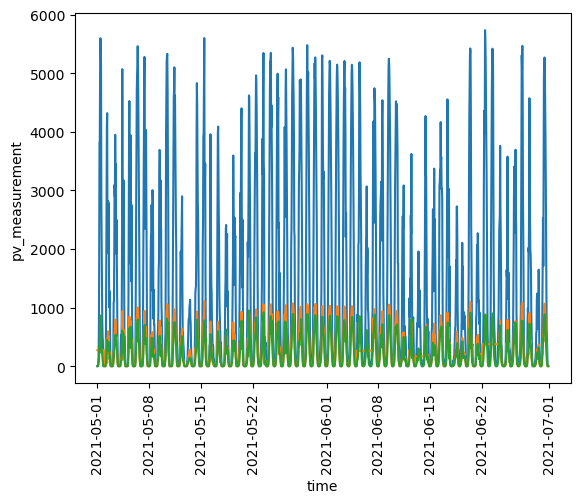

In [1317]:
sns.lineplot(data=Xy_test, x='time', y='pv_measurement', hue='building_id', legend=False)
plt.xticks(rotation=90);


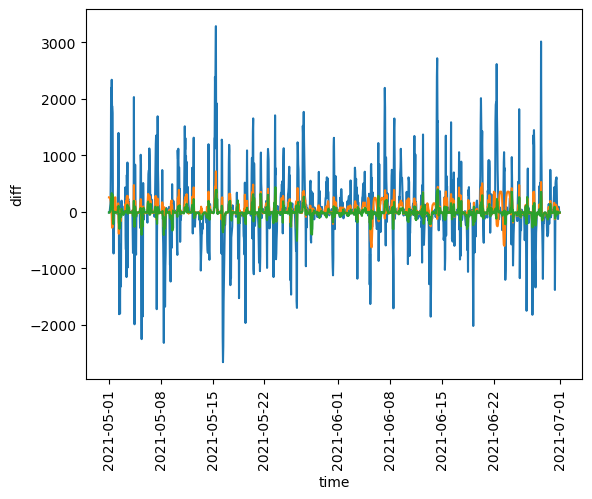

In [1318]:
sns.lineplot(data=Xy_test, x='time', y='diff', hue='building_id', legend=False)
plt.xticks(rotation=90);


In [1319]:
# Creating the submission file
m1.fit(X, y)

# prepare dataframes
y_test_pred = pd.Series(m1.predict(X_submission))
# y_test_pred = pd.Series(full_scaler.inverse_transform(
#     y_test_pred.values.reshape(-1, 1)).flatten())
#y_test_pred = y_scaler.inverse_transform(y_test_pred, X_t['building_id']).copy()

# remove negative predictions
y_test_pred.iloc[y_test_pred < 0] = 0

# rename columns etc.
y_test_pred = y_test_pred.reset_index().rename(
    columns={'pv_measurement': 'prediction', 'index': 'id'})

# save submission file
y_test_pred.to_csv(
    'feature_extraction.csv', index=False, header=True)


#